In [1]:
import os
import glob
import time
from datetime import datetime

import torch
import numpy as np
import pandas as pd

from State import State
from GenerateDemandMonthly import GenerateDemandMonthly

from PPO import PPO

Device set to : cpu


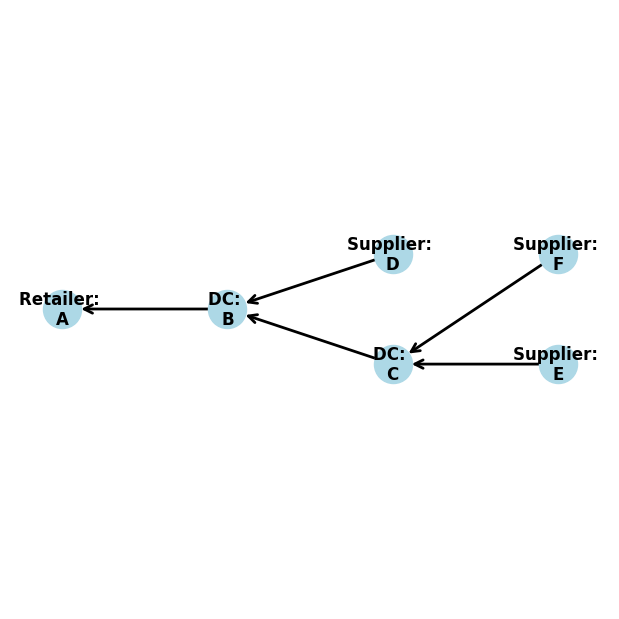

In [2]:
env = State()
env.create_state([-1, 0, 1, 1, 2, 2])
env.show_network()

In [3]:
has_continuous_action_space = False # continuous action space; else discrete
action_std = 0.6            # starting std for action distribution (Multivariate Normal)

eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99            # discount factor
K_epochs = 20
lr_actor = 0.00005      # learning rate for actor network
lr_critic = 0.0001       # learning rate for critic network

random_seed = 1234         # set random seed if required (0 = no random seed)

state_dim = 9
action_dim = 512

In [4]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.policy_old.load_state_dict(torch.load(map_location=torch.device('cpu'),f="rlmodel1.pt"))
ppo_agent.policy.load_state_dict(torch.load(map_location=torch.device('cpu'),f="rlmodel1.pt"))

<All keys matched successfully>

In [5]:
#### Generate New Demand ####
demand_generator = GenerateDemandMonthly()

df = pd.read_csv("../src/TOTALSA.csv")
mean = df['TOTALSA'].mean()
std = df['TOTALSA'].std()
period = 108
iterations = 100

demand_matrix = np.reshape(demand_generator.simulate_normal_no_season(\
            periods = period * iterations, mean=mean, std=std),\
                (iterations, period))

In [6]:
reward_RL = []

for demand_list in demand_matrix:
    reward_total = 0
    state = env.reset()
    env.set_demand_list(demand_list)
    done = False
    reward_sub = 0
    
    while not done:
        action = ppo_agent.select_action(state)
        state, reward, done = env.step(action)
        reward_sub += reward
        print(reward)
        if done:
            break
    reward_total += reward_sub
    reward_RL.append(reward_total)
        

766.5999999999999
517.1999999999998
1118.8
949.3999999999999
742.3999999999999
1107.1999999999998
1001.1999999999998
934.3999999999999
877.0
458.0
1177.8
1251.1999999999998
1117.1999999999998
611.5999999999999
982.3999999999999
1042.0
1082.6
1093.6
1122.8
579.1999999999998
735.0
889.3999999999999
969.5999999999999
1218.6
770.3999999999999
1345.8
1133.1999999999998
506.5999999999999
1058.0
1243.8
897.3999999999999
255.19999999999993
1335.8
-546.0
2633.6
549.4
1992.7999999999997
875.3999999999999
640.1999999999998
-634.0
-627.0
2158.0
3095.0
488.0
943.5999999999999
495.4
-479.0
1916.6
1861.0
-215.20000000000005
888.0
758.3999999999999
-574.0
1857.6
684.1999999999998
1566.1999999999998
-720.0
933.0
3193.6
369.4
-535.0
2657.0
819.8
831.0
1727.8
556.0
293.79999999999995
-634.0
911.1999999999998
2581.7999999999997
1428.6
15.0
-153.20000000000005
3114.6
-228.8
1704.8
-624.0
2842.2
1229.1999999999998
249.79999999999995
1094.1999999999998
902.8
746.8
960.0
-523.0
2378.0
1469.1999999999998
0.399

In [7]:
print(reward_RL)

[95325.20000000001, 101750.39999999998, 106076.59999999999, 104333.40000000001, 99993.2, 102906.40000000001, 100695.79999999994, 101862.6, 102617.39999999997, 100834.20000000001, 97611.2, 102021.4, 103608.6, 94431.19999999994, 105425.59999999996, 97727.2, 104213.4, 88223.19999999998, 96022.00000000004, 103779.4, 105129.0, 102069.20000000007, 92643.80000000002, 104172.99999999997, 99747.59999999999, 101321.60000000005, 100662.19999999997, 101534.00000000003, 87198.20000000004, 103240.79999999994, 98972.20000000001, 101691.99999999996, 103112.00000000003, 96379.39999999995, 103058.80000000003, 95482.59999999998, 99642.20000000001, 100796.19999999995, 106085.19999999998, 106238.20000000001, 103489.79999999996, 101631.20000000004, 103177.59999999998, 96686.19999999997, 99817.60000000002, 102273.39999999998, 99440.60000000002, 104865.00000000001, 95756.40000000002, 101788.59999999999, 106618.40000000004, 97994.80000000005, 97465.40000000004, 102511.59999999999, 95817.60000000002, 101170.4, 

In [8]:
## Starting inventory is fixed at 65
print(np.mean(reward_RL))

100931.67799999999


In [9]:
has_continuous_action_space = False # continuous action space; else discrete
action_std = 0.6            # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.03       # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.03               # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(1e5)  # action_std decay frequency (in num timesteps
eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99            # discount factor
K_epochs = 20
lr_actor = 0.00005      # learning rate for actor network
lr_critic = 0.0001       # learning rate for critic network

random_seed = 1234         # set random seed if required (0 = no random seed)

state_dim = 9
action_dim = 512

In [10]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.policy_old.load_state_dict(torch.load(map_location=torch.device('cpu'), f="rlmodel2.pt"))
ppo_agent.policy.load_state_dict(torch.load(map_location=torch.device('cpu'), f="rlmodel2.pt"))

<All keys matched successfully>

In [11]:
reward_RL = []

for demand_list in demand_matrix:
    reward_total = 0
    state = env.reset()
    env.set_demand_list(demand_list)
    done = False
    reward_sub = 0
    
    while not done:
        action = ppo_agent.select_action(state)
        state, reward, done = env.step(action)
        reward_sub += reward
        print(reward)
        if done:
            break
    reward_total += reward_sub
    reward_RL.append(reward_total)      


766.5999999999999
517.1999999999998
1124.8
930.3999999999999
672.3999999999999
1046.1999999999998
950.1999999999998
856.3999999999999
1041.0
566.0
1281.8
1303.1999999999998
1314.1999999999998
594.5999999999999
882.3999999999999
1056.0
1055.6
1012.5999999999999
1144.8
731.1999999999998
671.0
-459.0
2696.3999999999996
-573.0
-108.0
1830.6
2280.6
-46.60000000000002
495.5999999999999
1974.1999999999998
-507.0
2518.7999999999997
-477.0
2288.0
1193.8
1096.1999999999998
-582.0
2592.2
-552.0
2813.0
-482.0
-621.0
1862.7999999999997
2389.6
977.5999999999999
753.8
1005.3999999999999
-480.0
2477.7999999999997
992.5999999999999
696.5999999999999
1195.8
500.79999999999995
-561.0
976.1999999999998
2359.6
1129.6
664.5999999999999
-493.0
2348.6
1064.6
1331.3999999999999
694.8
1112.0
-447.0
-615.0
2542.6
740.1999999999998
2515.2
1133.1999999999998
-491.4
-517.0
196.39999999999998
3590.6
-899.0
2941.3999999999996
943.5999999999999
566.8
408.5999999999999
-22.40000000000009
2260.6
198.19999999999993
1227.

In [12]:
#Starting inventory can be chosen by the RL
print(reward_RL)

[99957.80000000003, 90977.40000000002, 102642.60000000002, 98882.4, 100481.0, 106864.40000000001, 105524.59999999993, 101664.60000000002, 90993.00000000004, 103987.20000000003, 83892.6, 101907.59999999998, 108907.19999999995, 83903.20000000001, 102567.60000000002, 88229.6, 87108.79999999996, 100925.20000000001, 105608.99999999999, 101204.20000000001, 99540.79999999999, 96299.99999999999, 106969.20000000001, 103297.0, 101930.40000000001, 106525.4, 105509.2, 109817.4, 95641.00000000003, 97968.0, 102168.59999999996, 101973.00000000003, 103229.80000000002, 95084.79999999996, 98718.00000000003, 97161.59999999996, 102196.20000000001, 81243.19999999998, 105703.60000000002, 109200.40000000002, 101933.8, 100911.20000000001, 105327.59999999996, 98160.59999999999, 98340.79999999999, 98172.40000000001, 97170.79999999999, 103823.0, 100439.39999999997, 91140.6, 103409.80000000002, 100506.6, 109019.8, 99896.60000000002, 104664.20000000001, 103679.19999999994, 96088.2, 90719.6, 106190.79999999994, 101

In [13]:
print(np.mean(reward_RL))

100068.48599999998
